<a href="https://colab.research.google.com/github/hrshankar2002/Pytorch-notes/blob/main/pytorch_nn_classification_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes
In a single epoch of training in a neural network, both forward propagation and backward propagation (often referred to as "backpropagation") are performed. Let's break down what happens in each step:</br>

* Forward Propagation: In this step, the input data is passed through the neural network, layer by layer, to generate predictions. Here's what typically happens during forward propagation:</br>

 * Each layer in the neural network performs its operation (e.g., matrix multiplication followed by activation function) using the input data and the current parameters (weights and biases).
 * The output of each layer becomes the input to the next layer until the final output is generated.</br>
* Loss Computation: After the forward pass, the predicted output is compared to the actual labels to compute the loss or error. This loss represents how well the model is performing on the training data.</br>

* Backward Propagation (Backpropagation): Once the loss is computed, the gradients of the loss with respect to the parameters of the network are calculated. Backpropagation involves propagating these gradients backward through the network to update the parameters (weights and biases) in the direction that minimizes the loss. Here's what typically happens during backpropagation:</br>

The gradients of the loss with respect to the parameters of the output layer are calculated first using techniques like the chain rule from calculus.
These gradients are then propagated backward through the network, layer by layer, using the chain rule to calculate the gradients of the loss with respect to the parameters of each layer.
The parameters of the network are updated using an optimization algorithm (e.g., gradient descent, Adam) based on these gradients to minimize the loss.
During training, this process of forward propagation followed by backward propagation is repeated for each batch of data in the training set for a certain number of epochs until the model converges or until a stopping criterion is met. Each epoch involves updating the parameters of the network based on the gradients computed from the entire training dataset.

# Getting data ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
import pandas as pd

df = pd.DataFrame({"X1":X[:, 0],
                   "X2":X[:, 1],
                   "label":y})
df.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [5]:
df.label.value_counts()

1    500
0    500
Name: label, dtype: int64

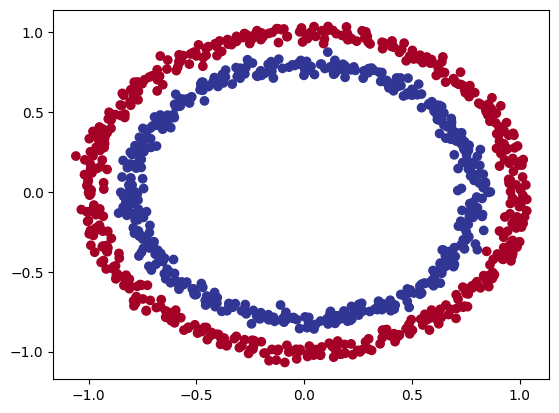

In [6]:
import matplotlib.pyplot as plt

plt.scatter(df["X1"], df["X2"], c = y, cmap = plt.cm.RdYlBu)
plt.show()

In [7]:
X.shape, y.shape, type(X), type(y), X.dtype, y.dtype

((1000, 2),
 (1000,),
 numpy.ndarray,
 numpy.ndarray,
 dtype('float64'),
 dtype('int64'))

In [8]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)
# random_state = 42 -> torch.manual_seed(42)

In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Building model

In [11]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [13]:
class CirlcleModelV0(nn.Module):
  def __init__(self):
    super().__init__();
    # self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
    # self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

    self.two_linear_layer = nn.Sequential(
        nn.Linear(in_features = 2, out_features = 5),
        nn.Linear(in_features = 5, out_features = 1)
    )

  def forward(self, X):
    # return self.layer_2(self.layer_1(X))
    return self.two_linear_layer(X)

model0 = CirlcleModelV0().to(device)
model0

CirlcleModelV0(
  (two_linear_layer): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [14]:
next(model0.parameters()).device

device(type='cuda', index=0)

In [15]:
model0.state_dict()

OrderedDict([('two_linear_layer.0.weight',
              tensor([[ 0.0941,  0.3786],
                      [ 0.0480, -0.6881],
                      [-0.6236,  0.3660],
                      [ 0.6542, -0.6842],
                      [-0.2407,  0.2761]], device='cuda:0')),
             ('two_linear_layer.0.bias',
              tensor([-0.6074, -0.1767,  0.0345, -0.1629,  0.6474], device='cuda:0')),
             ('two_linear_layer.1.weight',
              tensor([[ 0.0743,  0.0983, -0.1844,  0.3262, -0.3666]], device='cuda:0')),
             ('two_linear_layer.1.bias', tensor([-0.0983], device='cuda:0'))])

In [16]:
# Make predictions with the model(untrained)
with torch.inference_mode():
  untrained_preds = model0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.9128],
        [-0.8651],
        [-0.6228],
        [-0.9966],
        [ 0.0357],
        [ 0.0596],
        [-0.3281],
        [-0.1099],
        [-0.6510],
        [-0.8547]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# Loss fn and optimizer

In [17]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model0.parameters(), lr = 0.01)

In [18]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_true)) * 100
  return acc

# Model training

***Going from raw model outputs without being passed to activation functions (logits) to predicted labels (logits -> prediction probabilities -> prediction labels :<br>
(comparison with a threshold) ::<br>
If y_pred_probs >= 0.5, y=1 (class 1)<br>
If y_pred_probs < 0.5, y=0 (class 0)<br>
)<br>***


In [19]:
# 1.viewing first 5 outputs of forward pass on test data
model0.eval()
with torch.inference_mode():
  y_logits = model0(X_test.to(device))[:5]
y_logits, y_test[:5]

(tensor([[-0.9128],
         [-0.8651],
         [-0.6228],
         [-0.9966],
         [ 0.0357]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

In [20]:
# 2.use sigmoid activation fn on model logits to turn it to prediction probs
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.2864],
        [0.2963],
        [0.3491],
        [0.2696],
        [0.5089]], device='cuda:0')

In [21]:
# 3.find predicted labels
y_preds = torch.round(y_pred_probs)
y_preds, y_test[:5]

(tensor([[0.],
         [0.],
         [0.],
         [0.],
         [1.]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

In [22]:
# summary (logits -> prediction probabilities -> prediction labels )
y_pred_labels = torch.round(torch.sigmoid(model0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()


tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 1.], device='cuda:0')

In [23]:
y_test[:5] # not same as y_pred_labels as we usign random weights

tensor([1., 0., 1., 0., 1.])

# Building training & testing loop

In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 5000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

### training
for epoch in range(epochs+1):
  # 1.training
  model0.train()

  # 2.forward pass
  y_logits = model0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 3.calc loss / accuracy
  # loss = loss_fn(torch.sigmoid(y_logits),y_train)  # Using nn.BCELoss you need torch.sigmoid()
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()   # backprop
  optimizer.step()  # gradient descent

  ### testing
  model0.eval()
  with torch.inference_mode():
    test_logits = model0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 50 == 0:
      print(f"Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0, Loss: 0.7379, Accuracy: 43.12%, Test Loss: 0.7333, Test Accuracy: 45.50%
Epoch: 50, Loss: 0.7231, Accuracy: 46.25%, Test Loss: 0.7187, Test Accuracy: 45.50%
Epoch: 100, Loss: 0.7138, Accuracy: 47.25%, Test Loss: 0.7097, Test Accuracy: 47.00%
Epoch: 150, Loss: 0.7078, Accuracy: 47.88%, Test Loss: 0.7040, Test Accuracy: 47.50%
Epoch: 200, Loss: 0.7038, Accuracy: 47.88%, Test Loss: 0.7004, Test Accuracy: 48.00%
Epoch: 250, Loss: 0.7011, Accuracy: 48.88%, Test Loss: 0.6981, Test Accuracy: 46.50%
Epoch: 300, Loss: 0.6992, Accuracy: 48.75%, Test Loss: 0.6966, Test Accuracy: 47.50%
Epoch: 350, Loss: 0.6978, Accuracy: 49.00%, Test Loss: 0.6955, Test Accuracy: 47.00%
Epoch: 400, Loss: 0.6968, Accuracy: 49.25%, Test Loss: 0.6949, Test Accuracy: 47.00%
Epoch: 450, Loss: 0.6960, Accuracy: 50.00%, Test Loss: 0.6944, Test Accuracy: 46.50%
Epoch: 500, Loss: 0.6954, Accuracy: 50.25%, Test Loss: 0.6941, Test Accuracy: 47.50%
Epoch: 550, Loss: 0.6950, Accuracy: 50.38%, Test Loss: 0.6939, Test 

In [25]:
model0.to('cuda') # required due to helper fn changing device to cpu for numyp operations

CirlcleModelV0(
  (two_linear_layer): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

# Make predictions and evaluate model

***From the metrics it looks like our model is random guessing, hence visualize for further insights***

In [26]:
### plotting custom helper method

import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


In [27]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print('file exists')
else:
  print('downloading helper fn')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary, plot_predictions

downloading helper fn


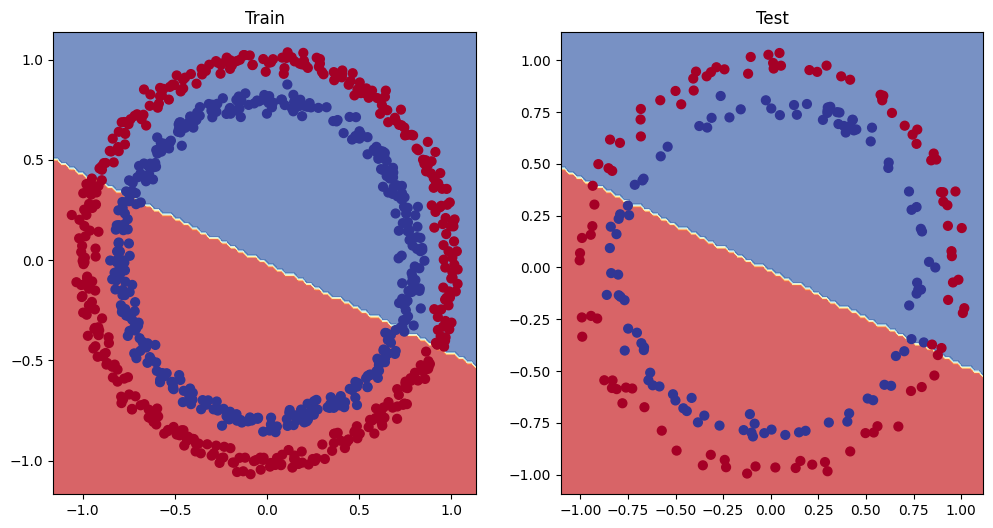

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)
plt.show()

***Inference is that model is classiying data by a linear line, hence the 50 per accuracy***

# How to improve model ?

## 1.Hyperparam tweaking :

* Add more layers
* Add more hidden units (5 --> 10)
* Fit for longer
* Changing activation fn(sigmoid -->)
* Change learning rate (eploding gradient problem, vanishing gradient problem)
* Change loss fn


<img src="https://raw.githubusercontent.com/hrshankar2002/Pytorch-notes/main/Slides/2024-02-24_17-57.png?token=GHSAT0AAAAAACNHN7LVKPP4HYXJRPHLYCM2ZO7TTDQ" width=630 height=400>

In [29]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]], device='cuda:0'),
 tensor([1., 0., 0., 0., 1.], device='cuda:0'))

In [30]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, X):
    return self.layer3(self.layer2(self.layer1(X)))

model1 = CircleModelV1().to(device)
model1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
# loss fn
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model1.parameters(),
                            lr=0.01)

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs+1):
  model1.train()

  y_logits = model1(X_train).squeeze()
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  with torch.inference_mode():
    test_logits = model1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch: 0, Loss: 0.6940, Accuracy: 51.1250, Test Loss: 0.6926, Test Accuracy: 51.0000
Epoch: 100, Loss: 0.6937, Accuracy: 51.1250, Test Loss: 0.6927, Test Accuracy: 50.0000
Epoch: 200, Loss: 0.6935, Accuracy: 51.1250, Test Loss: 0.6928, Test Accuracy: 49.5000
Epoch: 300, Loss: 0.6934, Accuracy: 51.1250, Test Loss: 0.6930, Test Accuracy: 49.0000
Epoch: 400, Loss: 0.6933, Accuracy: 51.1250, Test Loss: 0.6931, Test Accuracy: 48.5000
Epoch: 500, Loss: 0.6932, Accuracy: 51.1250, Test Loss: 0.6932, Test Accuracy: 49.5000
Epoch: 600, Loss: 0.6932, Accuracy: 51.1250, Test Loss: 0.6933, Test Accuracy: 53.0000
Epoch: 700, Loss: 0.6931, Accuracy: 51.1250, Test Loss: 0.6935, Test Accuracy: 50.5000
Epoch: 800, Loss: 0.6931, Accuracy: 51.1250, Test Loss: 0.6936, Test Accuracy: 51.0000
Epoch: 900, Loss: 0.6931, Accuracy: 51.1250, Test Loss: 0.6937, Test Accuracy: 47.5000
Epoch: 1000, Loss: 0.6930, Accuracy: 51.1250, Test Loss: 0.6938, Test Accuracy: 49.0000


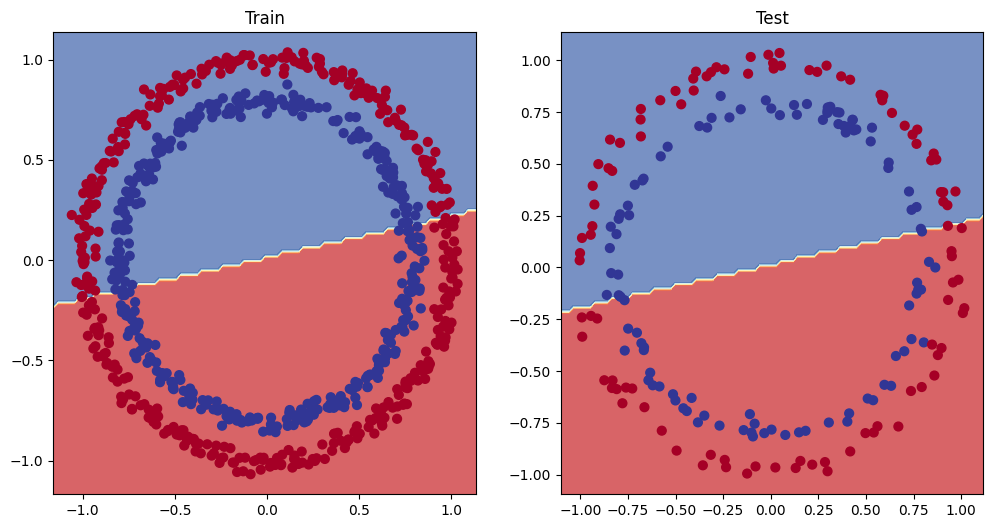

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)
plt.show()

# Preparing data to see if our model can model a straight line

In [34]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [35]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))


80 80 20 20


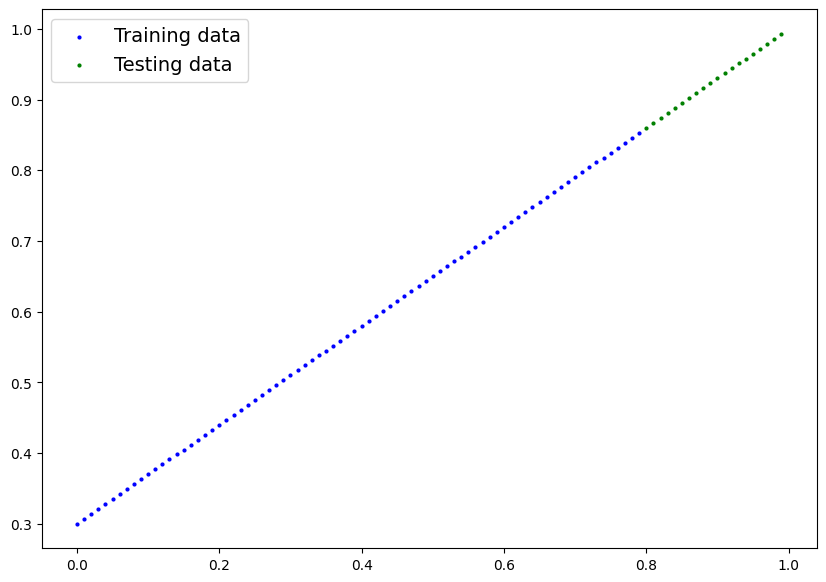

In [36]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression)

In [37]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [39]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 5000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 1000 | Train loss: 0.06466, Test loss: 0.02598
Epoch: 2000 | Train loss: 0.05256, Test loss: 0.00863
Epoch: 3000 | Train loss: 0.04366, Test loss: 0.02921
Epoch: 4000 | Train loss: 0.05445, Test loss: 0.00593


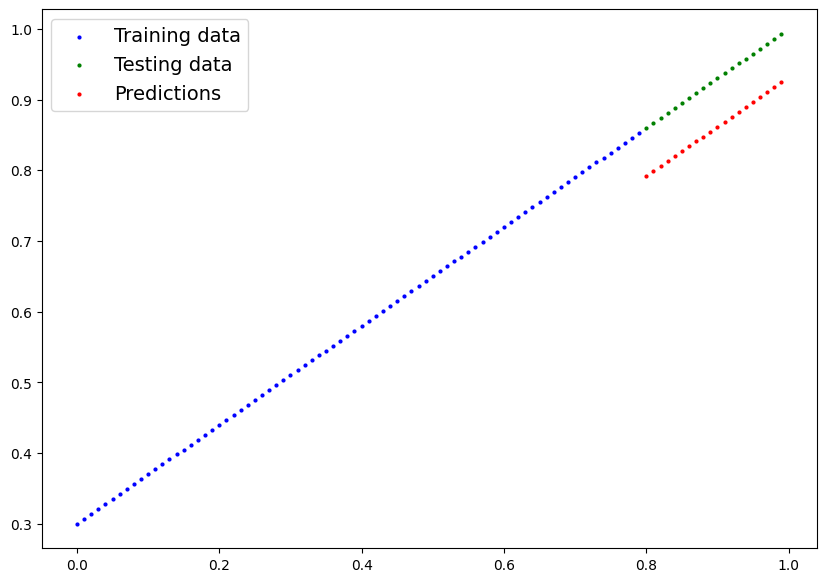

In [40]:
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());


# Recreating non-linear data (red and blue circles) with Non Linearity

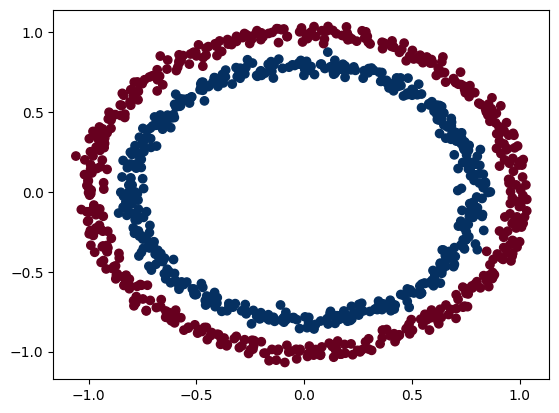

In [41]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [42]:
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [43]:
### Building a model with non-linearity

from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, X):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(X)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [44]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.01)

In [45]:
next(model_3.parameters()).device

device(type='cuda', index=0)

In [46]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 18000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs+1):
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69325, Test Accuracy: 50.00%
Epoch: 1000 | Loss: 0.69115, Accuracy: 53.00% | Test Loss: 0.69104, Test Accuracy: 52.50%
Epoch: 2000 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68941, Test Accuracy: 55.00%
Epoch: 3000 | Loss: 0.68794, Accuracy: 53.00% | Test Loss: 0.68725, Test Accuracy: 56.00%
Epoch: 4000 | Loss: 0.68515, Accuracy: 52.75% | Test Loss: 0.68413, Test Accuracy: 56.50%
Epoch: 5000 | Loss: 0.68100, Accuracy: 52.75% | Test Loss: 0.67943, Test Accuracy: 56.50%
Epoch: 6000 | Loss: 0.67510, Accuracy: 54.50% | Test Loss: 0.67287, Test Accuracy: 56.00%
Epoch: 7000 | Loss: 0.66650, Accuracy: 58.38% | Test Loss: 0.66323, Test Accuracy: 59.00%
Epoch: 8000 | Loss: 0.65140, Accuracy: 64.00% | Test Loss: 0.64755, Test Accuracy: 67.50%
Epoch: 9000 | Loss: 0.62316, Accuracy: 74.00% | Test Loss: 0.62137, Test Accuracy: 79.00%
Epoch: 10000 | Loss: 0.56720, Accuracy: 88.00% | Test Loss: 0.57351, Test Accuracy: 86.50%
Epoch: 11000

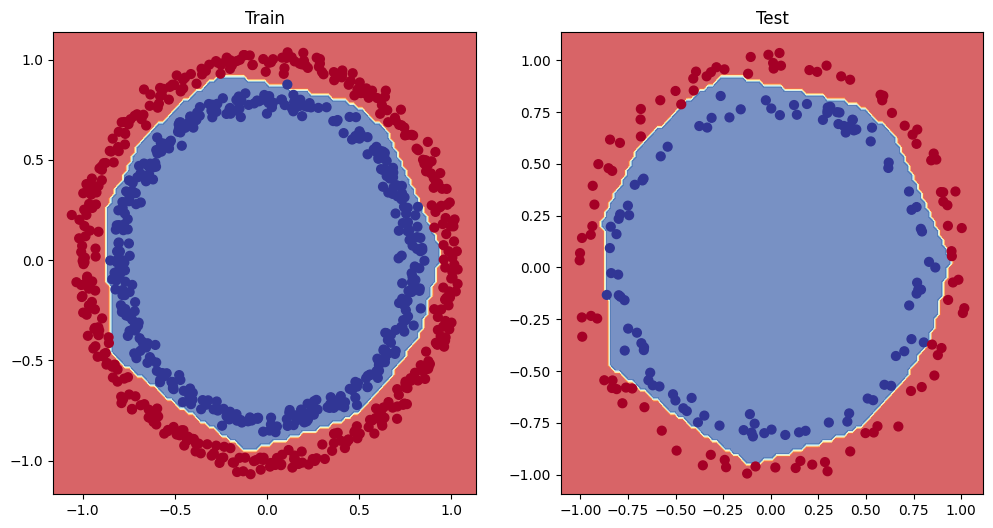

In [47]:
### model evaluation

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)
plt.show()

In [48]:
model_3.to(device).eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test)))

y_preds[:5], y_test[:5]

(tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

# How does ReLU enable Neural Networks to approximate continuous nonlinear functions?

CPWL functions are continuous functions with multiple linear portions. The slope is consistent on each portion, then changes abruptly at transition points by adding new linear functions.</br>


Example of CPWL function approximation using NN. At each transition point, a new ReLU function is added to/subtracted from the input to increase/decrease the slope.

<img src="https://miro.medium.com/v2/resize:fit:804/format:webp/1*EQvZp_DlBvSusRNzSld3kQ.png" width=550></br>

In a NN with one hidden layer using ReLU activation and a linear output layer, the activations are aggregated to form the CPWL target function. Each unit of the hidden layer is responsible for a linear piece. At each unit, a new ReLU function that corresponds to the changing of slope is added to produce the new slope (cf. Fig.2). Since this activation function is always positive, the weights of the output layer corresponding to units that increase the slope will be positive, and conversely, the weights corresponding to units that decreases the slope will be negative (cf. Fig.3). The new function is added at the transition point and does not contribute to the resulting function prior to (and sometimes after) that point due to the disabling range of the ReLU activation function.</br>

<img src="https://miro.medium.com/v2/resize:fit:726/format:webp/1*Idrd2TC0GYacIBl3yINMJQ.png" width=600>

Consider an example of a CPWL function that consists of 4 linear segments defined as below.

<img src="https://miro.medium.com/v2/resize:fit:776/format:webp/1*XOFrHCUKUrcHI-avX41y7A.png" width=600>

To represent this target function, we will use a NN with 1 hidden layer of 4 units and a linear layer that outputs the weighted sum of the previous layer’s activation outputs. Let’s determine the network’s parameters so that each unit in the hidden layer represents a segment of the target. For the sake of this example, the bias of the output layer (b2_0) is set to 0.

<img src="https://miro.medium.com/v2/resize:fit:1360/format:webp/1*SZtFtPxEG99ZZzzCLYDRmQ.png" width=650 height=250>

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*QuwhlWIMqlYzNFr8PGxVUA.png" width=580 height=150></br>
<img src="https://miro.medium.com/v2/resize:fit:716/format:webp/1*uwUsDgJYLSpz78hLX0ZN8g.png" width=580 height=250></br>

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*kwNrzqzdFd54l9vWu_JiUg.png" width=580>

<img src="https://miro.medium.com/v2/resize:fit:716/format:webp/1*a8QO-JTIm_mOz-4QTyUQoQ.png" width=580>

And so on for the corresponding sections. Hence it is a stack of linear as well as non linear functions.

***No vanishing gradient problem in ReLu(Non saturating activatn fn) as in sigmoid (saturating activation fns)***



<img src="https://raw.githubusercontent.com/hrshankar2002/Pytorch-notes/main/Slides/2024-02-27_00-09.png?token=GHSAT0AAAAAACNHN7LUXK2YXN4ZLHXFTNJUZO7T5CQ" width=600 height=300>

# Replicating non-linear activation functions

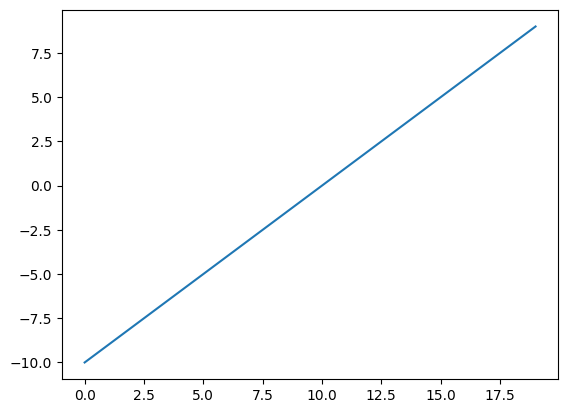

In [49]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
plt.plot(A);

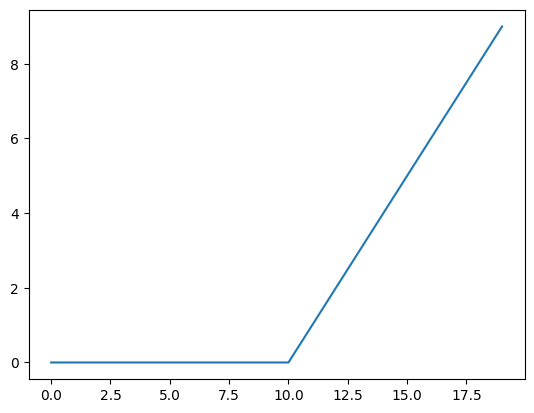

In [50]:
def relu(x): # or 'plt.plot(torch.relu(A))'
  return torch.maximum(torch.tensor(0), x)
plt.plot(relu(A));

# Multi class classification problem

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


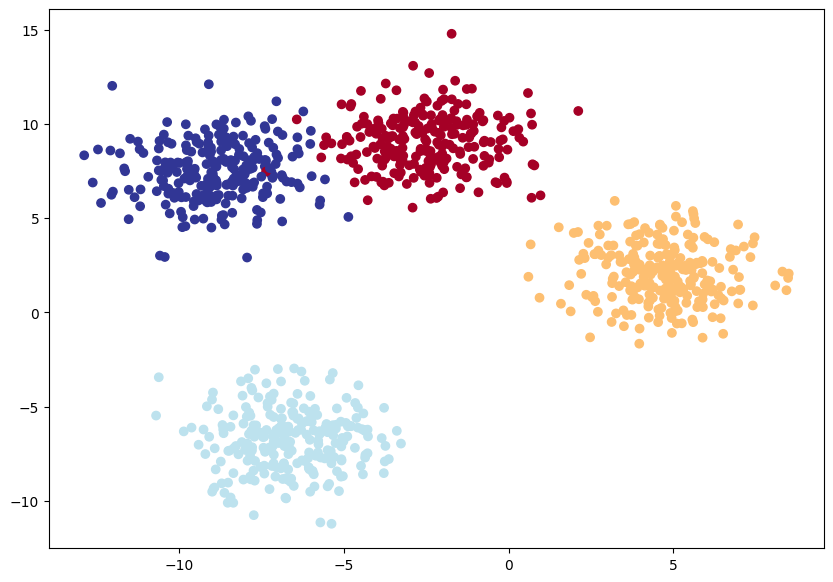

In [63]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [53]:
X_train.shape, torch.unique(y_blob_train)

(torch.Size([800, 2]), tensor([0, 1, 2, 3]))

In [73]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features),
    )

  def forward(self, X):
    return self.linear_layer_stack(X)

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

<img src="https://raw.githubusercontent.com/hrshankar2002/Pytorch-notes/main/Slides/2024-02-27_23-51.png?token=GHSAT0AAAAAACNHN7LV7YMG6ZETDZWMF4VCZO7S72Q" width=630 height=450>

In [74]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model_4.parameters(),
    lr = 0.01
)

In [75]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))
y_logits[:5], y_blob_test[:5]

(tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
         [ 1.7168, -1.2270,  1.7367,  2.1010],
         [ 2.2400,  0.7714,  2.6020,  1.0107],
         [-0.7993, -0.3723, -0.9138, -0.5388],
         [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0'),
 tensor([1, 3, 2, 1, 0], device='cuda:0'))

In [76]:
### Getting prediction probabilities for a multi-class PyTorch model (logits -> prediction probabilities -> prediction)
y_pred_probs = torch.softmax(y_logits, dim=1) # earlier torch.sigmoid
y_logits[:5], y_pred_probs[:5]

(tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
         [ 1.7168, -1.2270,  1.7367,  2.1010],
         [ 2.2400,  0.7714,  2.6020,  1.0107],
         [-0.7993, -0.3723, -0.9138, -0.5388],
         [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0'),
 tensor([[0.1872, 0.2918, 0.1495, 0.3715],
         [0.2824, 0.0149, 0.2881, 0.4147],
         [0.3380, 0.0778, 0.4854, 0.0989],
         [0.2118, 0.3246, 0.1889, 0.2748],
         [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0'))

In [77]:
y_preds = torch.argmax(y_pred_probs, dim=1) # earlier torch.round
y_preds[:5], y_blob_test[:5]

(tensor([3, 3, 2, 1, 3], device='cuda:0'),
 tensor([1, 3, 2, 1, 0], device='cuda:0'))

In [78]:
### Training and testing loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs+1):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch}, Train Loss: {loss:.4f}, Train Acc: {acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch: 0, Train Loss: 1.0432, Train Acc: 65.5000, Test Loss: 0.9634, Test Acc: 71.0000
Epoch: 100, Train Loss: 0.1515, Train Acc: 99.1250, Test Loss: 0.1484, Test Acc: 99.0000
Epoch: 200, Train Loss: 0.0832, Train Acc: 99.1250, Test Loss: 0.0778, Test Acc: 99.5000
Epoch: 300, Train Loss: 0.0605, Train Acc: 99.1250, Test Loss: 0.0540, Test Acc: 99.5000
Epoch: 400, Train Loss: 0.0496, Train Acc: 99.0000, Test Loss: 0.0425, Test Acc: 99.5000
Epoch: 500, Train Loss: 0.0434, Train Acc: 99.0000, Test Loss: 0.0358, Test Acc: 99.5000
Epoch: 600, Train Loss: 0.0394, Train Acc: 99.0000, Test Loss: 0.0315, Test Acc: 99.5000
Epoch: 700, Train Loss: 0.0367, Train Acc: 99.0000, Test Loss: 0.0285, Test Acc: 99.5000
Epoch: 800, Train Loss: 0.0347, Train Acc: 99.0000, Test Loss: 0.0262, Test Acc: 99.5000
Epoch: 900, Train Loss: 0.0331, Train Acc: 99.1250, Test Loss: 0.0245, Test Acc: 99.5000
Epoch: 1000, Train Loss: 0.0320, Train Acc: 99.1250, Test Loss: 0.0232, Test Acc: 99.5000


In [79]:
### Making predictions

model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]


tensor([[  4.2940,  10.2887, -14.8730,  -9.7635],
        [  4.9989, -12.0021,   3.3688,  10.6362],
        [ -5.5257, -13.2691,  20.9724,  12.7752],
        [  1.8183,   7.5157,  -8.5841,  -6.9881],
        [  8.0126,   3.2455, -14.5911,  -3.6419],
        [  5.5694, -14.9057,   4.9944,  13.2491],
        [ -5.9129, -10.1287,  18.8541,   9.9279],
        [  7.0286,  -0.7835,  -9.5512,   0.1483],
        [ -5.5211, -18.4993,  25.5049,  17.5766],
        [  7.2634,   0.6888, -11.1974,  -1.2252]], device='cuda:0')

In [80]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")


Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


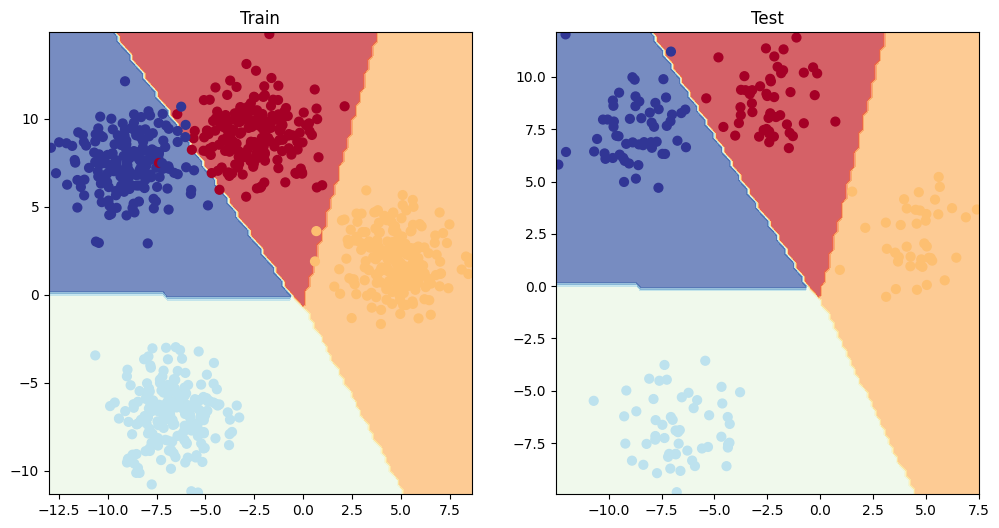

In [81]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# Inference
For lineary seperable data, we dont be needing relu activation layers.

In summary, using ReLU activation layers in neural networks for linearly separable data allows the network to introduce non-linearity while preserving the linear separability of the data along positive directions, which can aid in learning more complex decision boundaries and improving classification performance.

<img src="https://raw.githubusercontent.com/hrshankar2002/Pytorch-notes/ad4e6d7acc3b178227633dcc0fc563a3efee187f/Slides/2024-02-29_01-40.png?token=GHSAT0AAAAAACNHN7LUWQGDUHKTT2ZFQ3I2ZO7UHEA">

In [86]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)


tensor(0.9950, device='cuda:0')